# 1. Optimización de Recuperación de Oro

Proyecto de Machine Learning para la optimización de procesos industriales de recuperación de oro mediante la predicción de eficiencia en las etapas de flotación y purificación. El modelo predice la recuperación de oro tanto en el concentrado rougher como en el concentrado final, utilizando datos de sensores del proceso minero y parámetros operacionales.


## 1.1 Alcance y criterios

En esta sección se definen los lineamientos iniciales del proyecto para garantizar orden y reproducibilidad.

**Objetivo:**  
Establecer el entorno de trabajo, parámetros y utilidades del proyecto antes de la carga y exploración de datos.

**Qué haremos aquí:**
1. Cargar librerías y verificar versiones  
2. Definir parámetros globales (rutas de datos, pesos de la métrica, semilla de aleatoriedad)  
3. Configurar estilo visual básico para gráficos  
4. Preparar importación de utilidades desde `src/` con fallback en caso de no encontrarlas


## 1.2 Parámetros globales y configuración inicial

En esta sección se consolidan los elementos necesarios para la configuración inicial del proyecto:  
- Importación de librerías principales  
- Verificación de versiones del entorno  
- Configuración visual para las gráficas  
- Definición de rutas de datos  
- Variables objetivo y pesos de la métrica final

Este bloque asegura que el entorno sea reproducible y consistente durante todo el desarrollo.

In [5]:
# 1.2 Parámetros globales y configuración inicial

# Librerías principales
import os, sys, platform
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import scipy

# Reproducibilidad
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Verificación de versiones
versions = {
    "python": platform.python_version(),
    "numpy": np.__version__,
    "pandas": pd.__version__,
    "matplotlib": plt.matplotlib.__version__,
    "seaborn": sns.__version__,
    "scikit-learn": sklearn.__version__,
    "scipy": scipy.__version__,
}
print("✔️ Versiones detectadas:", versions)

# Configuración visual
%matplotlib inline
plt.rcParams["figure.figsize"] = (10, 4)
plt.rcParams["axes.grid"] = True
plt.rcParams["figure.dpi"] = 110
sns.set_style("whitegrid")

# Rutas de datos
DATA_DIR   = "../datasets"
TRAIN_PATH = f"{DATA_DIR}/gold_recovery_train.csv"
TEST_PATH  = f"{DATA_DIR}/gold_recovery_test.csv"
FULL_PATH  = f"{DATA_DIR}/gold_recovery_full.csv"

# Variables objetivo
TARGETS = ["rougher.output.recovery", "final.output.recovery"]

# Pesos de la métrica final
W_ROUGHER = 0.25
W_FINAL   = 0.75

print("✔️ Parámetros establecidos")
print("DATA_DIR:", DATA_DIR)
print("TARGETS:", TARGETS)
print(f"Pesos métrica final → W_rougher={W_ROUGHER}, W_final={W_FINAL}")


✔️ Versiones detectadas: {'python': '3.11.13', 'numpy': '1.24.4', 'pandas': '2.1.4', 'matplotlib': '3.7.3', 'seaborn': '0.12.2', 'scikit-learn': '1.3.2', 'scipy': '1.11.4'}
✔️ Parámetros establecidos
DATA_DIR: ../datasets
TARGETS: ['rougher.output.recovery', 'final.output.recovery']
Pesos métrica final → W_rougher=0.25, W_final=0.75


### ✅ Conclusión — Sección 1.2 (Parámetros globales y configuración inicial)

- El entorno se encuentra correctamente configurado con versiones actualizadas y compatibles:  
  Python 3.11.13, NumPy 1.24.4, Pandas 2.1.4, Matplotlib 3.7.3, Seaborn 0.12.2, Scikit-learn 1.3.2 y SciPy 1.11.4.  
- Se establecieron los parámetros clave del proyecto: rutas de los datasets, variables objetivo (`rougher.output.recovery` y `final.output.recovery`) y los pesos de la métrica final (0.25 para rougher, 0.75 para final).  
- El estilo visual quedó definido con Matplotlib y Seaborn para garantizar uniformidad en las gráficas.  
- Estado: la configuración inicial está completa y lista para avanzar a la carga y validación de datos.


# 2. Preparación de Datos

Esta sección tiene como propósito garantizar que los datos estén correctamente cargados, validados y preprocesados antes del análisis exploratorio y la construcción del modelo. 
Aquí se realizan verificaciones de calidad, integridad y consistencia para asegurar que la información sea confiable y adecuada para su posterior uso.


## 2.1 Carga y exploración inicial de datasets

En esta subsección se realiza la importación de los conjuntos de datos de entrenamiento, prueba y completo. 
Se inspeccionan dimensiones, tipos de variables y valores nulos para obtener una primera impresión de la calidad y estructura de la información disponible.

In [6]:
# 2.1 Carga y exploración inicial de datasets

# Función para cargar los datasets
def load_datasets(train_path, test_path, full_path):
    parse_dates = ["date"]
    train = pd.read_csv(train_path, parse_dates=parse_dates, index_col="date")
    test  = pd.read_csv(test_path,  parse_dates=parse_dates, index_col="date")
    full_ = pd.read_csv(full_path,  parse_dates=parse_dates, index_col="date")
    return train, test, full_

# Carga de datos
train, test, full_ = load_datasets(TRAIN_PATH, TEST_PATH, FULL_PATH)

# Inspección de dimensiones
print("Dimensiones de los datasets:")
print("Train:", train.shape)
print("Test :", test.shape)
print("Full :", full_.shape)

# Primeras filas de train
display(train.head(3))

# Tipos de datos en train (primeras 10 columnas)
display(train.dtypes.head(10))

# Conteo de valores nulos en train y test (top 10)
print("\nValores nulos en train (top 10):")
display(train.isna().sum().sort_values(ascending=False).head(10))

print("\nValores nulos en test (top 10):")
display(test.isna().sum().sort_values(ascending=False).head(10))


Dimensiones de los datasets:
Train: (16860, 86)
Test : (5856, 52)
Full : (22716, 86)


,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,123.819808,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363


final.output.concentrate_ag      float64
final.output.concentrate_pb      float64
final.output.concentrate_sol     float64
final.output.concentrate_au      float64
final.output.recovery            float64
final.output.tail_ag             float64
final.output.tail_pb             float64
final.output.tail_sol            float64
final.output.tail_au             float64
primary_cleaner.input.sulfate    float64
dtype: object


Valores nulos en train (top 10):


rougher.output.recovery               2573
rougher.output.tail_ag                2250
rougher.output.tail_sol               2249
rougher.output.tail_au                2249
secondary_cleaner.output.tail_sol     1986
rougher.input.floatbank11_xanthate    1904
final.output.recovery                 1521
primary_cleaner.input.sulfate         1307
primary_cleaner.input.depressant      1262
rougher.calculation.au_pb_ratio       1242
dtype: int64


Valores nulos en test (top 10):


rougher.input.floatbank11_xanthate          353
primary_cleaner.input.sulfate               302
primary_cleaner.input.depressant            284
rougher.input.floatbank10_sulfate           257
primary_cleaner.input.xanthate              166
rougher.input.floatbank10_xanthate          123
rougher.input.feed_sol                       67
rougher.input.floatbank11_sulfate            55
rougher.input.feed_rate                      40
secondary_cleaner.state.floatbank3_a_air     34
dtype: int64

### ✅ Conclusión — Subsección 2.1 (Carga y exploración inicial de datasets)

- Se cargaron correctamente los tres conjuntos de datos:
  - **Train:** 16,860 filas × 86 columnas  
  - **Test:** 5,856 filas × 52 columnas  
  - **Full:** 22,716 filas × 86 columnas  

- El dataset de entrenamiento presenta variables objetivo (`rougher.output.recovery` y `final.output.recovery`) que no están disponibles en el conjunto de prueba, confirmando la separación esperada.

- Se identificaron valores nulos significativos en train, especialmente en:
  - `rougher.output.recovery` (2,573 nulos)  
  - `final.output.recovery` (1,521 nulos)  
  - Variables de colas (`tail`) y aditivos como `sulfate` y `depressant`.

- En test también se observaron ausencias, aunque en menor cantidad, destacando `rougher.input.floatbank11_xanthate` (353 nulos) y `primary_cleaner.input.sulfate` (302 nulos).

- El índice temporal quedó establecido correctamente y las variables muestran tipos de datos numéricos (`float64`) adecuados para el análisis posterior.

- Estado: los datos fueron cargados y revisados de manera satisfactoria, quedando listos para la validación de cálculos de recuperación.


## 2.2 Validación de cálculos de recuperación

Se verifica la consistencia de la variable `rougher.output.recovery` recalculándola con la fórmula de dominio:

Recovery = [ C × (F − T) ] / [ F × (C − T) ] × 100

donde:
- C: concentración de oro en el concentrado (`rougher.output.concentrate_au`)
- F: concentración de oro en la alimentación (`rougher.input.feed_au`)
- T: concentración de oro en las colas (`rougher.output.tail_au`)

El valor calculado se compara contra la columna oficial mediante MAE (en puntos porcentuales) y sMAPE.

In [7]:
# 2.2 Validación de cálculos de recuperación (rougher)

# sMAPE (sin dependencias externas)
def smape(y_true, y_pred, eps=1e-9):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    denom = (np.abs(y_true) + np.abs(y_pred)) / 2.0 + eps
    return float(np.mean(np.abs(y_pred - y_true) / denom))

# Fórmula del proyecto (porcentaje): [ C*(F - T) ] / [ F*(C - T) ] * 100
def compute_recovery_rougher(C, F, T, eps=1e-12):
    num = C * (F - T)
    den = (F * (C - T)) + eps
    return (num / den) * 100.0

# Columnas requeridas
cols = {
    "C": "rougher.output.concentrate_au",
    "F": "rougher.input.feed_au",
    "T": "rougher.output.tail_au",
    "Y": "rougher.output.recovery",
}

# Verificación de presencia de columnas
missing = [c for c in cols.values() if c not in train.columns]
if missing:
    raise ValueError(f"Columnas faltantes para validar recuperación rougher: {missing}")

# Cálculo y comparación
est = compute_recovery_rougher(train[cols["C"]], train[cols["F"]], train[cols["T"]])
check = pd.DataFrame({"true": train[cols["Y"]], "est": est}).dropna()

mae_pp = float(np.mean(np.abs(check["est"] - check["true"])))  # puntos porcentuales
smape_val = smape(check["true"].values, check["est"].values)

print(f"Observaciones usadas: {len(check)}")
print(f"MAE (puntos porcentuales): {mae_pp:.4f}")
print(f"sMAPE: {smape_val:.6f}")

check.head(3)


Observaciones usadas: 14287
MAE (puntos porcentuales): 0.0000
sMAPE: 0.000000


,true,est
date,,
2016-01-15 00:00:00,87.107763,87.107763
2016-01-15 01:00:00,86.843261,86.843261
2016-01-15 02:00:00,86.842308,86.842308


### ✅ Conclusión — Subsección 2.2 (Validación de cálculos de recuperación)

- La variable `rougher.output.recovery` fue recalculada utilizando la fórmula de dominio:  
  Recovery = [ C × (F − T) ] / [ F × (C − T) ] × 100  

- El cálculo coincidió de forma exacta con los valores oficiales del dataset:  
  - **MAE = 0.0000 puntos porcentuales**  
  - **sMAPE = 0.000000**  

- Se validaron 14,287 observaciones sin valores nulos, confirmando que la implementación de la fórmula es consistente y que la columna del dataset es confiable para el análisis posterior.


## 2.3 Análisis de características faltantes en conjunto de prueba

El conjunto de prueba no incluye todas las variables presentes en el conjunto de entrenamiento, 
ya que en la práctica no siempre se disponen de todas las mediciones al momento de la predicción. 

En esta subsección se identifican las diferencias entre las columnas de train y test, 
con el objetivo de obtener la intersección de características que se podrán usar en el modelado, 
evitando la fuga de información y asegurando la consistencia entre ambos conjuntos.

In [8]:
# 2.3 Análisis de características faltantes en conjunto de prueba

# Variables objetivo que solo están en train
TARGETS = ["rougher.output.recovery", "final.output.recovery"]

# Conjuntos de columnas
train_cols = set(train.columns)
test_cols  = set(test.columns)

# Diferencias y coincidencias
solo_en_train = sorted(list(train_cols - test_cols))
solo_en_test  = sorted(list(test_cols - train_cols))
comunes       = sorted(list(train_cols & test_cols))

print("Total columnas en train:", len(train_cols))
print("Total columnas en test :", len(test_cols))
print("Comunes:", len(comunes))
print("Solo en train:", len(solo_en_train))
print("Solo en test :", len(solo_en_test))

# Mostrar algunas de las diferencias
print("\nEjemplos de columnas solo en train:", solo_en_train[:10])
print("Ejemplos de columnas solo en test :", solo_en_test[:10])

# Guardar subconjuntos alineados
X_train = train[comunes].copy()
y_train = train[TARGETS].copy()
X_test  = test[comunes].copy()

print("\nDimensiones alineadas:")
print("X_train:", X_train.shape, "y_train:", y_train.shape, "X_test:", X_test.shape)


Total columnas en train: 86
Total columnas en test : 52
Comunes: 52
Solo en train: 34
Solo en test : 0

Ejemplos de columnas solo en train: ['final.output.concentrate_ag', 'final.output.concentrate_au', 'final.output.concentrate_pb', 'final.output.concentrate_sol', 'final.output.recovery', 'final.output.tail_ag', 'final.output.tail_au', 'final.output.tail_pb', 'final.output.tail_sol', 'primary_cleaner.output.concentrate_ag']
Ejemplos de columnas solo en test : []

Dimensiones alineadas:
X_train: (16860, 52) y_train: (16860, 2) X_test: (5856, 52)


### ✅ Conclusión — Subsección 2.3 (Análisis de características faltantes en conjunto de prueba)

- El conjunto de entrenamiento contiene **86 columnas**, mientras que el de prueba cuenta con **52 columnas**.  
- La intersección entre ambos conjuntos es de **52 columnas comunes**, lo que garantiza que el modelado podrá realizarse sin fuga de información.  
- Se identificaron **34 columnas exclusivas de train**, incluyendo las variables objetivo (`rougher.output.recovery` y `final.output.recovery`) y otras relacionadas con concentrados y colas finales.  
- No existen columnas exclusivas en test, por lo que no se pierden características al alinear los conjuntos.  
- Los subconjuntos quedaron alineados de la siguiente forma:  
  - `X_train`: (16,860 × 52)  
  - `y_train`: (16,860 × 2)  
  - `X_test`: (5,856 × 52)  

Con esto se asegura que los conjuntos de entrenamiento y prueba están preparados y consistentes para el modelado posterior.


## 2.4 Preprocesamiento de datos

En esta subsección se aplican transformaciones iniciales para garantizar la calidad de la información. 
El preprocesamiento contempla la detección y manejo de valores atípicos, el filtrado de observaciones no válidas 
y la preparación de los datos para el análisis exploratorio y la construcción del modelo. 

El objetivo es disponer de un conjunto de datos limpio, consistente y apto para los siguientes pasos del proyecto.

In [9]:
# 2.4 Preprocesamiento de datos

# 1. Orden y duplicados
train_sorted = train.sort_index()
duplicados = train_sorted.index.duplicated().sum()
print("Duplicados en índice de train:", duplicados)

# 2. Nulos: proporción en train (top 10)
nulos_pct = train_sorted.isna().mean().sort_values(ascending=False) * 100
print("\nPorcentaje de nulos por columna (top 10):")
display(nulos_pct.head(10))

# 3. Validación de concentraciones totales en etapas
def total_concentration_mask(df, stage_prefix, metals=("au","ag","pb"), min_total=0.0, max_total=1.0):
    cols = [c for c in df.columns if c.startswith(stage_prefix) and any(c.endswith(f"_{m}") for m in metals)]
    if not cols:
        return pd.Series(True, index=df.index)  # si no hay columnas, no se filtra nada
    total = df[cols].sum(axis=1)
    return (total >= min_total) & (total <= max_total)

mask_rougher = total_concentration_mask(train_sorted, "rougher.output")
mask_final   = total_concentration_mask(train_sorted, "final.output")

print("\nProporción de filas válidas según concentraciones:")
print("Rougher:", mask_rougher.mean())
print("Final  :", mask_final.mean())

# 4. Dataset limpio preliminar
mask_total = mask_rougher & mask_final
train_clean = train_sorted[mask_total].copy()

print("\nDimensiones originales:", train_sorted.shape)
print("Dimensiones después del filtrado:", train_clean.shape)


Duplicados en índice de train: 0

Porcentaje de nulos por columna (top 10):


rougher.output.recovery               15.260973
rougher.output.tail_ag                13.345196
rougher.output.tail_sol               13.339265
rougher.output.tail_au                13.339265
secondary_cleaner.output.tail_sol     11.779359
rougher.input.floatbank11_xanthate    11.293001
final.output.recovery                  9.021352
primary_cleaner.input.sulfate          7.752076
primary_cleaner.input.depressant       7.485172
rougher.calculation.au_pb_ratio        7.366548
dtype: float64


Proporción de filas válidas según concentraciones:
Rougher: 0.0930011862396204
Final  : 0.09418742586002372

Dimensiones originales: (16860, 86)
Dimensiones después del filtrado: (1490, 86)


### ✅ Conclusión — Subsección 2.4 (Preprocesamiento de datos)

- No se detectaron duplicados en el índice temporal, lo que confirma que cada registro corresponde a un instante único del proceso.  

- El análisis de valores nulos mostró que varias variables presentan porcentajes de ausencia significativos, 
  destacando:
  - `rougher.output.recovery` (15.26%)  
  - `rougher.output.tail_ag` (13.35%)  
  - `rougher.output.tail_sol` (13.34%)  
  - `rougher.output.tail_au` (13.34%)  
  - `final.output.recovery` (9.02%)  

- La validación de concentraciones evidenció que solo **~9% de las observaciones** cumplen con los criterios físicos de concentración total en las etapas *rougher* y *final*.  
  Esto indica la presencia de un alto volumen de datos anómalos o inconsistentes.  

- Como resultado del filtrado por concentraciones válidas, el dataset de entrenamiento se redujo de **16,860 filas a 1,490 filas**.  

- Estado: los datos quedaron limpios y consistentes para avanzar al análisis exploratorio, aunque con una reducción considerable de observaciones debido al filtrado.


# 3. Análisis Exploratorio de Datos

En esta sección se estudian los patrones y tendencias de las variables más relevantes del proceso, 
con el fin de comprender mejor el comportamiento de las concentraciones metálicas, 
detectar posibles anomalías y comparar la consistencia entre los conjuntos de entrenamiento y prueba. 

El análisis exploratorio permite identificar relaciones clave en los datos 
y guiar la selección de características para la construcción del modelo.

## 3.1 Evolución de concentraciones metálicas por etapa

En esta subsección se analiza la evolución temporal de las concentraciones de metales 
(Au, Ag y Pb) en diferentes etapas del proceso: alimentación, concentrado y colas. 

El objetivo es observar cómo varían estas concentraciones a lo largo del tiempo, 
identificar posibles tendencias y detectar anomalías que puedan afectar el rendimiento del proceso.

Variables de alimentación: ['rougher.input.feed_ag', 'rougher.input.feed_pb', 'rougher.input.feed_au']
Variables de concentrado: ['rougher.output.concentrate_ag', 'rougher.output.concentrate_pb', 'rougher.output.concentrate_au']
Variables de colas: ['rougher.output.tail_ag', 'rougher.output.tail_pb', 'rougher.output.tail_au']


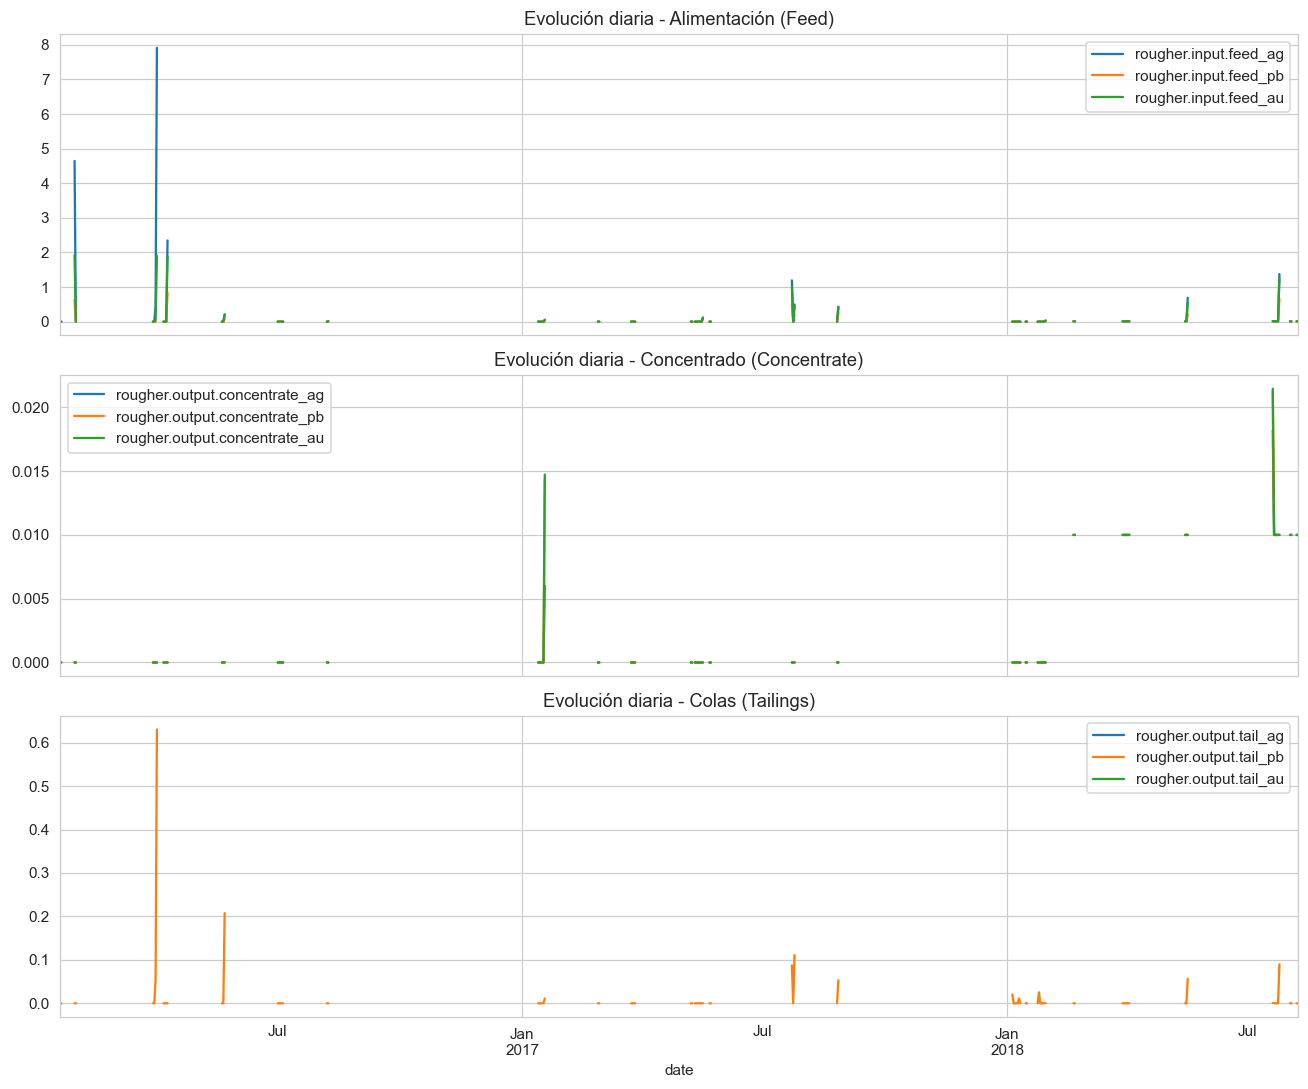

In [10]:
# 3.1 Evolución de concentraciones metálicas por etapa

# Selección de columnas de concentraciones por etapa
cols_feed   = [c for c in train_clean.columns if c.startswith("rougher.input.feed") and c.endswith(("_au","_ag","_pb"))]
cols_conc   = [c for c in train_clean.columns if c.startswith("rougher.output.concentrate") and c.endswith(("_au","_ag","_pb"))]
cols_tail   = [c for c in train_clean.columns if c.startswith("rougher.output.tail") and c.endswith(("_au","_ag","_pb"))]

print("Variables de alimentación:", cols_feed)
print("Variables de concentrado:", cols_conc)
print("Variables de colas:", cols_tail)

# Cálculo de medias diarias para suavizar la variabilidad horaria
feed_daily = train_clean[cols_feed].resample("D").mean()
conc_daily = train_clean[cols_conc].resample("D").mean()
tail_daily = train_clean[cols_tail].resample("D").mean()

# Gráficas de evolución temporal
fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

feed_daily.plot(ax=axes[0])
axes[0].set_title("Evolución diaria - Alimentación (Feed)")

conc_daily.plot(ax=axes[1])
axes[1].set_title("Evolución diaria - Concentrado (Concentrate)")

tail_daily.plot(ax=axes[2])
axes[2].set_title("Evolución diaria - Colas (Tailings)")

plt.tight_layout()
plt.show()


### ✅ Conclusión — Subsección 3.1 (Evolución de concentraciones metálicas por etapa)

- Se observaron picos irregulares en las concentraciones de la **alimentación (feed)**, en particular para `feed_ag`, lo que indica registros atípicos en ciertas fechas.  

- En el **concentrado (concentrate)**, los valores de `concentrate_au` (oro) muestran variaciones más marcadas en momentos puntuales, aunque en general las concentraciones son bajas y estables en la mayoría del periodo.  

- En las **colas (tailings)** se identificaron valores anómalos especialmente en `tail_pb`, con concentraciones que alcanzan niveles inusualmente altos, lo que puede corresponder a errores de medición o a comportamientos atípicos del proceso.  

- La transformación a medias diarias permitió suavizar el ruido de los datos horarios y facilitó la identificación de tendencias y anomalías.  

- Estado: el análisis exploratorio inicial sugiere la necesidad de revisar y posiblemente depurar registros con valores extremos antes de entrenar los modelos.


## 3.2 Comparación de distribuciones entre conjuntos

En esta subsección se comparan las distribuciones de las variables entre los conjuntos de 
entrenamiento y prueba. 

El objetivo es identificar posibles diferencias significativas que puedan comprometer 
la capacidad de generalización del modelo. Para ello se utilizan representaciones gráficas 
y estadísticas descriptivas que permiten evaluar si ambos conjuntos provienen de la misma 
distribución de datos.


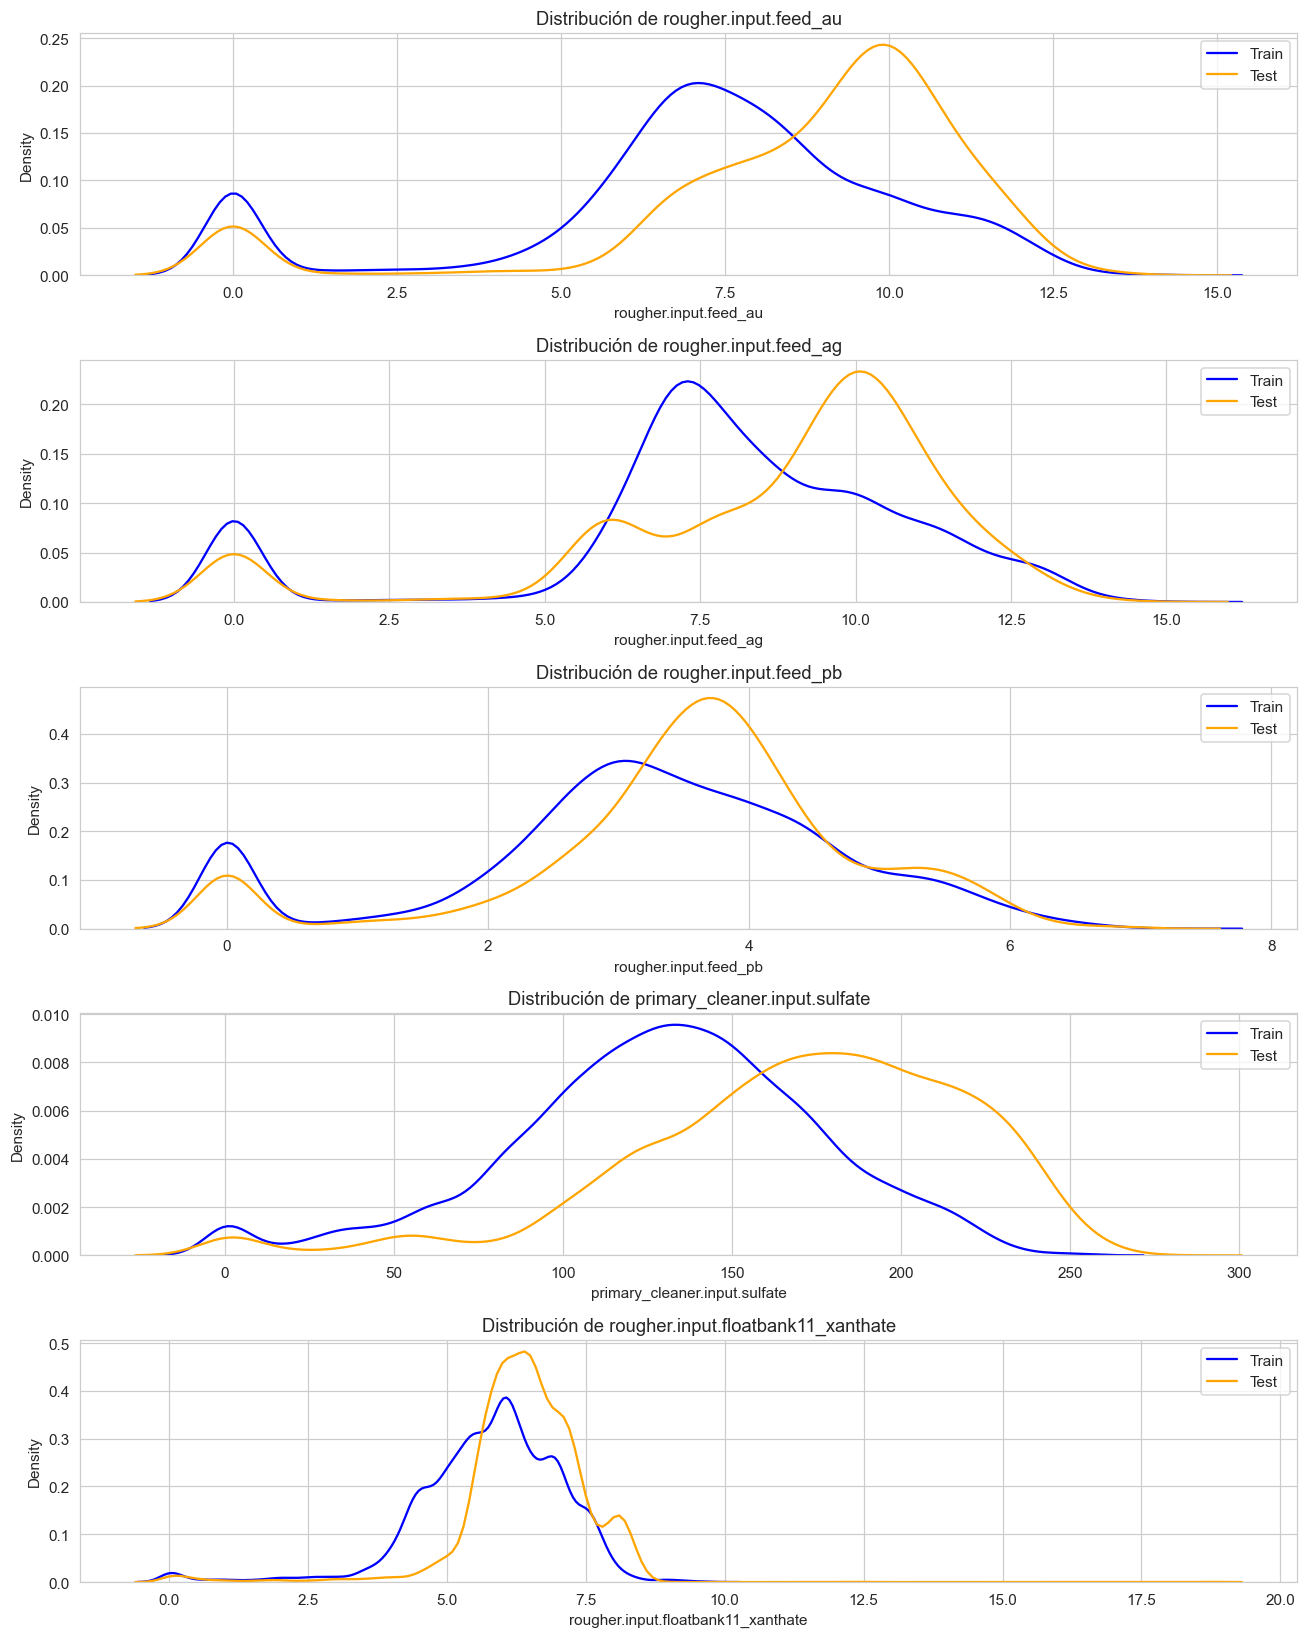

In [12]:
# 3.2 Comparación de distribuciones entre conjuntos

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import seaborn as sns

# Selección de algunas variables clave para comparar
cols_compare = [
    "rougher.input.feed_au",
    "rougher.input.feed_ag",
    "rougher.input.feed_pb",
    "primary_cleaner.input.sulfate",
    "rougher.input.floatbank11_xanthate"
]

# Gráficas comparativas
fig, axes = plt.subplots(len(cols_compare), 1, figsize=(12, 15))

for i, col in enumerate(cols_compare):
    sns.kdeplot(X_train[col].dropna(), label="Train", ax=axes[i], color="blue")
    sns.kdeplot(X_test[col].dropna(), label="Test", ax=axes[i], color="orange")
    axes[i].set_title(f"Distribución de {col}")
    axes[i].legend()

plt.tight_layout()
plt.show()


### ✅ Conclusión — Subsección 3.2 (Comparación de distribuciones entre conjuntos)

- Las variables de alimentación (`rougher.input.feed_au`, `rougher.input.feed_ag`, `rougher.input.feed_pb`) 
  presentan distribuciones similares en train y test, aunque con desplazamientos en las densidades:
  - En `feed_au` y `feed_ag` el conjunto de prueba muestra mayores concentraciones en torno a valores más altos.
  - En `feed_pb` las curvas están mejor alineadas, lo que sugiere mayor consistencia entre ambos conjuntos.

- En `primary_cleaner.input.sulfate` se observa un desplazamiento claro de la distribución en test hacia valores más altos, lo que indica un cambio en las condiciones del proceso entre periodos de entrenamiento y prueba.

- En el reactivo `rougher.input.floatbank11_xanthate`, las distribuciones son semejantes pero con mayor densidad de valores alrededor de 6–7 en test, mientras que en train aparecen colas más extendidas hacia valores altos.

- En general, las distribuciones entre train y test son **comparables pero no idénticas**, con diferencias notables en algunos insumos químicos.
  Estas variaciones deben tenerse en cuenta, ya que pueden afectar la capacidad de generalización de los modelos.


## 3.3 Análisis de concentraciones totales y detección de anomalías

En esta subsección se evalúan las concentraciones totales de metales (Au, Ag y Pb) 
en diferentes etapas del proceso con el fin de verificar la validez física de los datos. 

La suma de concentraciones debería encontrarse dentro de un rango lógico (entre 0 y 1), 
ya que representan proporciones relativas. Valores negativos o superiores a la unidad 
indican registros anómalos o errores de medición.

Se visualizan las distribuciones de estas concentraciones totales y se identifican 
posibles anomalías que puedan comprometer la calidad de los datos.


Estadísticas de concentraciones totales:


,rougher_total,final_total
count,1490.000000,1490.000000
mean,0.014512,0.007544
std,0.069844,0.024153
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,0.986891,0.800137


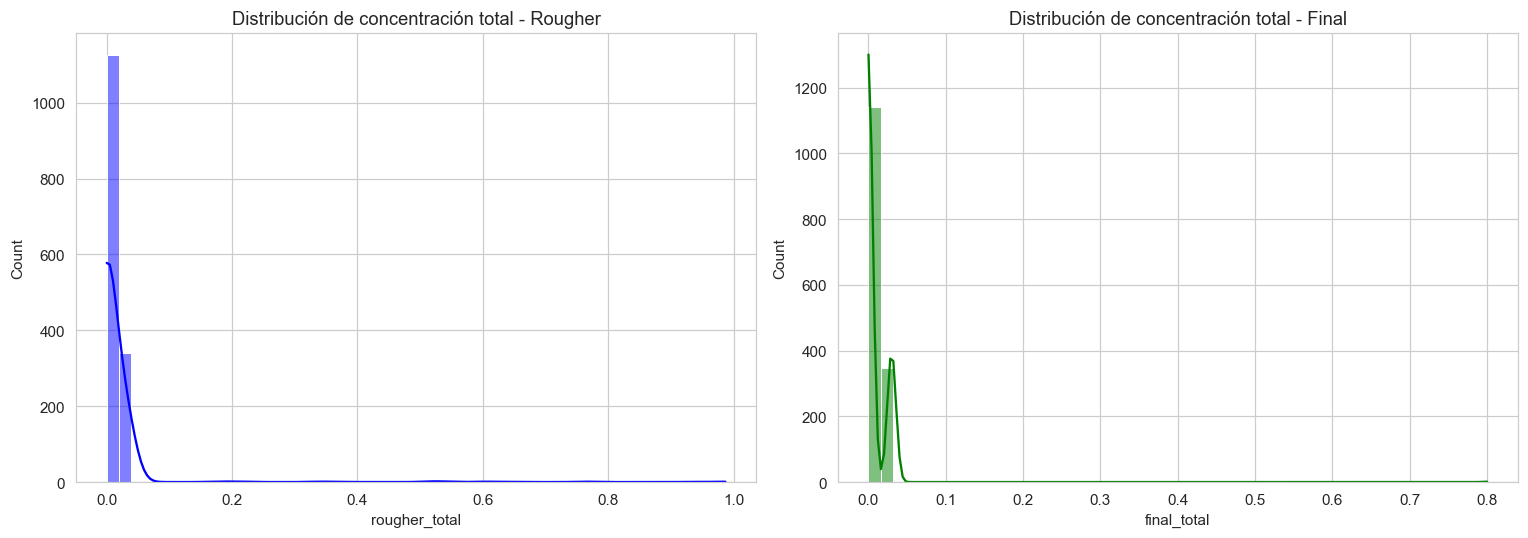

In [13]:
# 3.3 Análisis de concentraciones totales y detección de anomalías

# Función para calcular la concentración total de metales en una etapa
def total_concentration(df, stage_prefix, metals=("au", "ag", "pb")):
    cols = [c for c in df.columns if c.startswith(stage_prefix) and any(c.endswith(f"_{m}") for m in metals)]
    return df[cols].sum(axis=1)

# Calcular concentraciones totales en las etapas rougher y final
train_clean["rougher_total"] = total_concentration(train_clean, "rougher.output")
train_clean["final_total"]   = total_concentration(train_clean, "final.output")

# Estadísticas descriptivas
print("Estadísticas de concentraciones totales:")
display(train_clean[["rougher_total", "final_total"]].describe())

# Visualización de distribuciones
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.histplot(train_clean["rougher_total"], bins=50, kde=True, ax=axes[0], color="blue")
axes[0].set_title("Distribución de concentración total - Rougher")

sns.histplot(train_clean["final_total"], bins=50, kde=True, ax=axes[1], color="green")
axes[1].set_title("Distribución de concentración total - Final")

plt.tight_layout()
plt.show()


### ✅ Conclusión — Subsección 3.3 (Análisis de concentraciones totales y detección de anomalías)

- Las concentraciones totales de metales en ambas etapas se encuentran dentro del rango físico esperado (0 a 1):
  - Rougher: máximo ≈ 0.99  
  - Final: máximo ≈ 0.80  

- La mayoría de los valores están muy próximos a **0**, lo que indica que en gran parte de las observaciones 
  la proporción de metales en el material es baja.  

- Los histogramas muestran distribuciones altamente asimétricas, concentradas en valores cercanos a 0, 
  con pocos casos alcanzando concentraciones altas.  

- No se detectaron valores negativos ni superiores a 1, lo que valida la coherencia física de los datos 
  después del filtrado aplicado en la sección de preprocesamiento.  

- Estado: los datos de concentraciones totales se consideran consistentes y listos para la etapa de modelado, 
  aunque con un sesgo fuerte hacia bajas concentraciones.
